# Import Libraries & Load Data

In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.applications.densenet import DenseNet201
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings
warnings.simplefilter("ignore")

2024-06-05 13:12:10.849480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
!pip install tqdm

In [6]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))          
            IMG.append(np.array(img))
            
    return IMG

benign_train = np.array(Dataset_loader('breast-cancer-dataset/Train/Benign',224))
malign_train = np.array(Dataset_loader('breast-cancer-dataset/Train/Malignant',224))
benign_test = np.array(Dataset_loader('breast-cancer-dataset/Test/Benign',224))
malign_test = np.array(Dataset_loader('breast-cancer-dataset/Test/Malignant',224))

100%|██████████| 120/120 [00:00<00:00, 135.52it/s]


In [7]:
benign_train.shape

(640, 224, 224, 3)

# Data Preprocessing

In [8]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

In [9]:
# Merge data 
x_train = np.concatenate((benign_train, malign_train), axis = 0)
y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
x_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [10]:
# Shuffle train data
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]

In [11]:
# Shuffle test data
s = np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test = x_test[s]
y_test = y_test[s]

In [12]:
# To categorical
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [13]:
# split dataset into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.2, 
    random_state=11
)

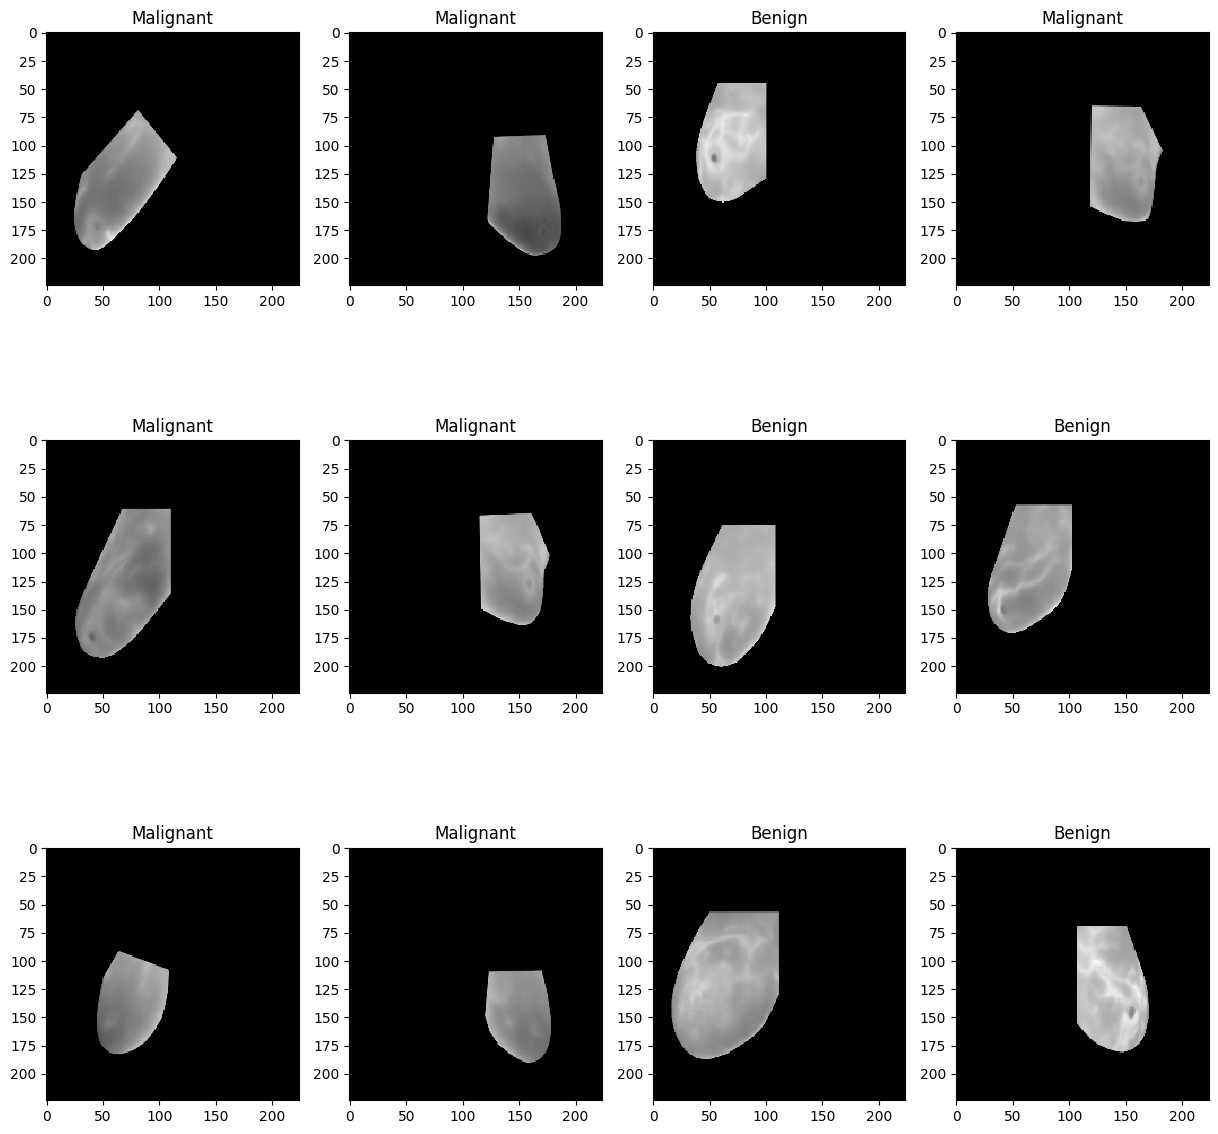

In [14]:
# visualization image
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [23]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Define Model

In [22]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

res = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
# resnet = DenseNet201(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
)

model = build_model(res ,lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23600002 (90.03 MB)
Trainable params: 23

# Training & Evaluation

In [24]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                verbose=1,factor=0.2, min_lr=1e-7)


history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(x_val, y_val),
)

Epoch 1/100
64/64 [==============================] - 269s 4s/step - loss: 0.6809 - accuracy: 0.6992 - val_loss: 7908.9282 - val_accuracy: 0.5156
Epoch 2/100
64/64 [==============================] - 283s 4s/step - loss: 0.5230 - accuracy: 0.7646 - val_loss: 446.8978 - val_accuracy: 0.5156
Epoch 3/100
64/64 [==============================] - 263s 4s/step - loss: 0.4947 - accuracy: 0.7725 - val_loss: 2.7439 - val_accuracy: 0.5156
Epoch 4/100
64/64 [==============================] - 270s 4s/step - loss: 0.4648 - accuracy: 0.7793 - val_loss: 186.7531 - val_accuracy: 0.5156
Epoch 5/100
64/64 [==============================] - 286s 4s/step - loss: 0.4800 - accuracy: 0.7920 - val_loss: 4.3874 - val_accuracy: 0.8086
Epoch 6/100
64/64 [==============================] - 268s 4s/step - loss: 0.4314 - accuracy: 0.8164 - val_loss: 0.4163 - val_accuracy: 0.8867
Epoch 7/100
64/64 [==============================] - 265s 4s/step - loss: 0.4659 - accuracy: 0.7939 - val_loss: 14.9300 - val_accuracy: 0.531

In [26]:

model.save_weights("resnet_model_weights.h5")


In [28]:
from tensorflow.keras.models import save_model
save_model(model, "model.h5")

<Axes: >

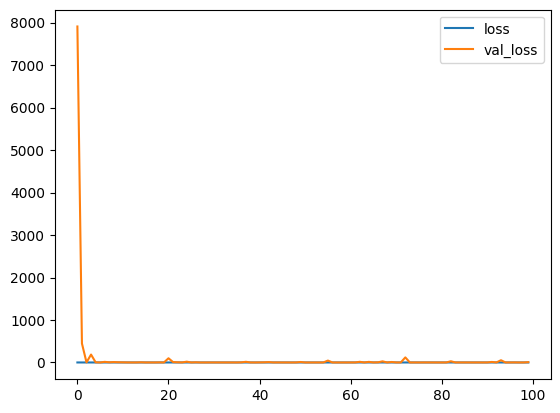

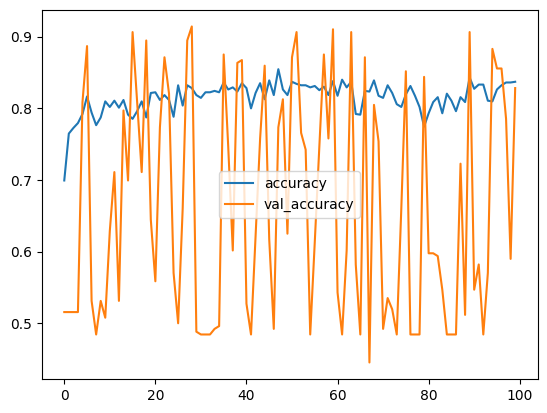

In [29]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

# Prediction

In [30]:
y_val_pred = model.predict(x_val)

8/8 [==============================] - 22s 2s/step


In [31]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

0.828125

In [32]:
y_pred = model.predict(x_test)

8/8 [==============================] - 20s 2s/step


In [33]:
steps = 10
predictions = []

for i in tqdm(range(steps)):
    preds = model.predict_generator(train_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(x_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [03:32<00:00, 21.26s/it]


# Confusion Matrix

Confusion matrix, without normalization
[[118   2]
 [ 88  32]]


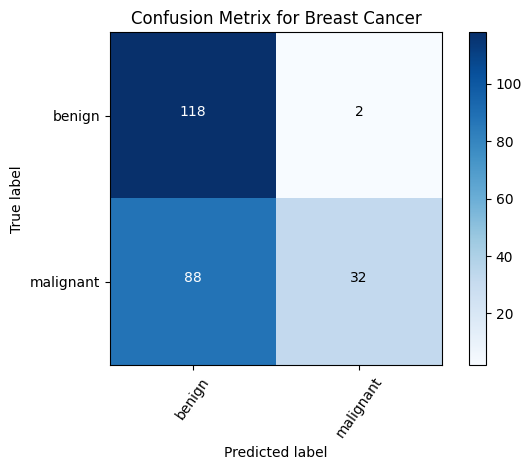

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

Confusion matrix, without normalization
[[118   2]
 [ 75  45]]


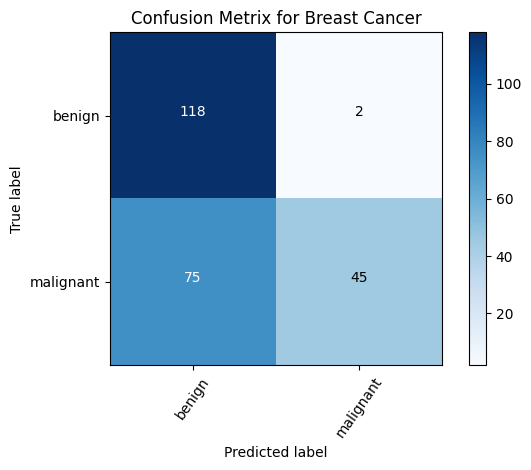

In [35]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

# Classification Report

In [36]:
from sklearn.metrics import classification_report
classification_report( np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.61      0.98      0.75       120\n           1       0.96      0.38      0.54       120\n\n    accuracy                           0.68       240\n   macro avg       0.78      0.68      0.65       240\nweighted avg       0.78      0.68      0.65       240\n'

# ROC & AUC

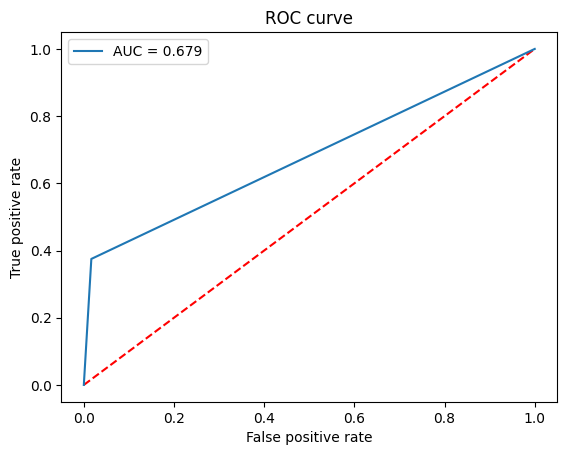

In [37]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [41]:
model.load_weights('resnet_model_weights.h5')

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2



In [58]:
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)

resnet50 Functional
global_average_pooling2d_1 GlobalAveragePooling2D
dropout_1 Dropout
batch_normalization_1 BatchNormalization
dense_1 Dense


In [59]:
# Access the resnet50 functional model
resnet50_model = model.get_layer('resnet50')

# Print all layers within the resnet50 model
for layer in resnet50_model.layers:
    print(layer.name, layer.__class__.__name__)


input_2 InputLayer
conv1_pad ZeroPadding2D
conv1_conv Conv2D
conv1_bn BatchNormalization
conv1_relu Activation
pool1_pad ZeroPadding2D
pool1_pool MaxPooling2D
conv2_block1_1_conv Conv2D
conv2_block1_1_bn BatchNormalization
conv2_block1_1_relu Activation
conv2_block1_2_conv Conv2D
conv2_block1_2_bn BatchNormalization
conv2_block1_2_relu Activation
conv2_block1_0_conv Conv2D
conv2_block1_3_conv Conv2D
conv2_block1_0_bn BatchNormalization
conv2_block1_3_bn BatchNormalization
conv2_block1_add Add
conv2_block1_out Activation
conv2_block2_1_conv Conv2D
conv2_block2_1_bn BatchNormalization
conv2_block2_1_relu Activation
conv2_block2_2_conv Conv2D
conv2_block2_2_bn BatchNormalization
conv2_block2_2_relu Activation
conv2_block2_3_conv Conv2D
conv2_block2_3_bn BatchNormalization
conv2_block2_add Add
conv2_block2_out Activation
conv2_block3_1_conv Conv2D
conv2_block3_1_bn BatchNormalization
conv2_block3_1_relu Activation
conv2_block3_2_conv Conv2D
conv2_block3_2_bn BatchNormalization
conv2_block3

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2

# Assuming 'model' is already defined and loaded

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the resnet50 model layer
    resnet50_model = model.get_layer('resnet50')

    # Create a new model that maps the input to the activations of the last convolutional layer as well as the output predictions
    grad_model = Model(
        inputs=model.input,
        outputs=[resnet50_model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradients of the top predicted class for our input image
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the outputs of the conv layer by the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to the heatmap to discard negative values and normalize it
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    cv2.imwrite(cam_path, superimposed_img)

    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [67]:
# Example usage
img_path = 'breast-cancer-dataset/Test/Benign/PAC_64_DN3-esq.png'  # Replace with the path to your image
img_array = preprocess_input(get_img_array(img_path, size=(224, 224)))

# Find the last convolutional layer in the resnet50 model
resnet50_model = model.get_layer('resnet50')
last_conv_layer_name = find_last_conv_layer(resnet50_model)
print("Last convolutional layer in resnet50 model:", last_conv_layer_name)

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(img_path, heatmap)


Last convolutional layer in resnet50 model: conv5_block3_3_conv


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [68]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283838 sha256=0a4af2fcc595a8bf8176b36877f6570917b1a2a1a7e98121e4dbdc0f80b0a482
  Stored in directory: /Users/iramkamdar/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 825ms/step


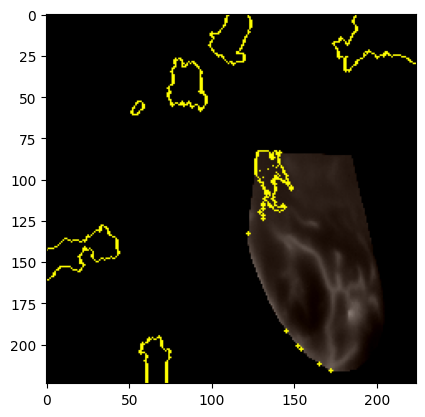

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def predict_fn(images):
    images = np.array([preprocess_input(image.img_to_array(img)) for img in images])
    preds = model.predict(images)
    return preds

def explain_prediction(img_path, top_labels=2, hide_color=0, num_samples=1000):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = preprocess_input(image.img_to_array(img))

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_array, predict_fn, top_labels=top_labels, hide_color=hide_color, num_samples=num_samples)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.show()


img_path = 'breast-cancer-dataset/Test/Benign/PAC_64_DN3-esq.png'  
explain_prediction(img_path)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 800ms/step


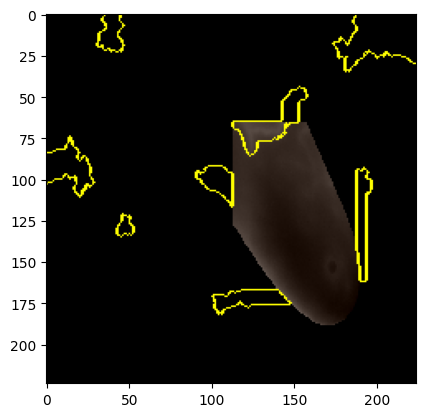

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_img_array(img_path, size):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def predict_fn(images):
    # Preprocess the images and make predictions using the model
    images = np.array([preprocess_input(image.img_to_array(img)) for img in images])
    preds = model.predict(images)
    return preds

def explain_prediction(img_path, top_labels=2, hide_color=0, num_samples=1000):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = preprocess_input(image.img_to_array(img))

    # Initialize the LIME image explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Generate an explanation for the image
    explanation = explainer.explain_instance(img_array, predict_fn, top_labels=top_labels, hide_color=hide_color, num_samples=num_samples)

    # Visualize the explanation
    # Get the image and mask for the top predicted label
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    
    # Display the original image with the important regions highlighted
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.show()

img_path = 'breast-cancer-dataset/Test/Malignant/PAC_48_DN11-esq.png'  # Replace with the path to your image
explain_prediction(img_path)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 801ms/step


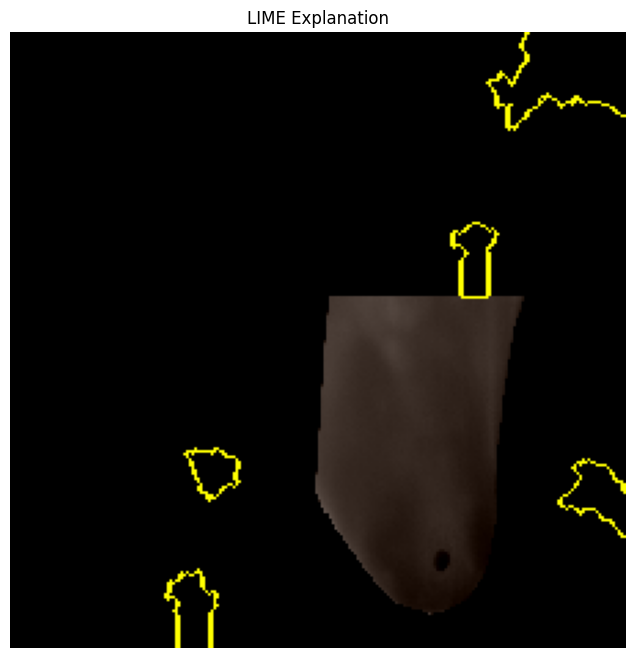

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Assuming 'model' is already defined and loaded

def get_img_array(img_path, size):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def predict_fn(images):
    # Preprocess the images and make predictions using the model
    images = np.array([preprocess_input(image.img_to_array(img)) for img in images])
    preds = model.predict(images)
    return preds

def explain_prediction(img_path, top_labels=2, hide_color=0, num_samples=1000):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = preprocess_input(image.img_to_array(img))

    # Initialize the LIME image explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Generate an explanation for the image
    explanation = explainer.explain_instance(img_array, predict_fn, top_labels=top_labels, hide_color=hide_color, num_samples=num_samples)

    # Visualize the explanation
    # Get the image and mask for the top predicted label
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    
    # Display the original image with the important regions highlighted
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title('LIME Explanation')
    plt.axis('off')
    plt.show()

# Example usage
img_path = 'breast-cancer-dataset/Test/Malignant/PAC_14_DN16-esq.png'  # Replace with the path to your image
explain_prediction(img_path)


In [79]:
def diagnose_breast_cancer(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = preprocess_input(image.img_to_array(img))
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    
    # Map the predicted class to a label
    class_labels = {0: 'Benign', 1: 'Malignant'}
    diagnosis = class_labels[predicted_class]
    
    # Print the diagnosis
    print(f'The model predicts that the image is: {diagnosis}')
    
    # Display the image
    plt.imshow(img)
    plt.title(f'Diagnosis: {diagnosis}')
    plt.axis('off')
    plt.show()


In [77]:
from tensorflow.keras.models import load_model

# Load the trained model from the HDF5 file
model = load_model('model.h5')

# Verify the model by printing its summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23600002 (90.03 MB)
Trainable params: 23

1/1 [==============================] - 1s 1s/step
The model predicts that the image is: Malignant


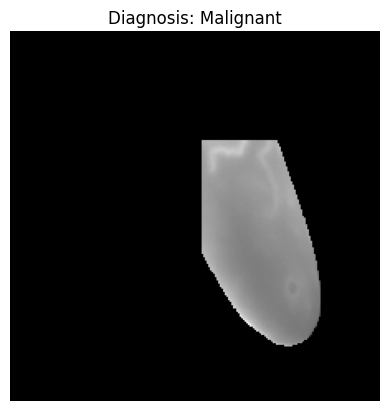

In [80]:

img_path = 'PAC_48_DN19-esq.png'  
diagnose_breast_cancer(img_path)
